In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [48]:
df_full_market = pd.read_csv('./Polymarket data-interview - Full Markets.csv')
df_all_market = pd.read_csv('./Polymarket data-interview - All Markets.csv')
df_vol_market = pd.read_csv('./Polymarket data-interview - Volatility Markets.csv')

dfs = [df_full_market, df_all_market, df_vol_market]
df_names = ['Full Markets', 'All Markets', 'Volatility Markets']

for name, df in zip(df_names, dfs):
    print(f"\n{'='*60}")
    print(f"{name}, shape: {df.shape}")

    print(df.head())
    print(f"\nColumns: {df.columns.tolist()}")
    print(f"\nData types:\n{df.dtypes}")


Full Markets, shape: (3054, 19)
                                            question answer1 answer2  \
0  Will Trump sign the Epstein Disclosure Bill on...     Yes      No   
1  Fed decreases interest rates by 25 bps after D...     Yes      No   
2  Will Trump sign the Epstein Disclosure Bill on...     Yes      No   
3  US x Venezuela military engagement by November...     Yes      No   
4  Will Trump sign the Epstein Disclosure Bill on...     Yes      No   

   neg_risk  spread  best_bid  best_ask  rewards_daily_rate  \
0      True   0.010     0.480     0.490                1200   
1      True   0.010     0.530     0.540                 500   
2      True   0.030     0.320     0.350                 500   
3     False   0.010     0.110     0.120                 300   
4      True   0.007     0.005     0.012                 300   

   bid_reward_per_100  ask_reward_per_100  gm_reward_per_100  \
0              165.06               85.60             118.87   
1                0.21      

# PART 1 - CORE DATA ANALYSIS

## 1. Spread and Liquidity

### Analysis Approach:
- **Spread = Best Ask - Best Bid** => Represents the cost of immediate round-trip trading
- **Tight spreads** indicate:
  - **High Liquidity**: Market makers compete aggressively, deep order books
  - **Strong Competition**: Multiple MMs fighting for order flow
  - **Lower Edge**: Smaller profit per trade, but higher turnover potential
  
- **Wide spreads** indicate:
  - **Low Liquidity**: Difficulty entering/exiting positions without price impact
  - **Less Competition**: Fewer active market makers
  - **Higher Edge**: Larger profit margins per trade to compensate for risk
  - **Higher Risk**: Potential for adverse selection, informed trading, or event uncertainty

In [ ]:
results_spread = {}

for name, df in zip(df_names, dfs):
    df_analysis = df.copy()
    
    df_analysis['spread'] = df_analysis['best_ask'] - df_analysis['best_bid']
    df_analysis['spread_bps'] = df_analysis['spread'] * 10000
    df_analysis['mid_price'] = (df_analysis['best_ask'] + df_analysis['best_bid']) / 2
    df_analysis['spread_pct'] = (df_analysis['spread'] / df_analysis['mid_price']) * 100
    
    tightest = df_analysis.nsmallest(3, 'spread')
    widest = df_analysis.nlargest(3, 'spread')
    
    results_spread[name] = {
        'tightest': tightest,
        'widest': widest,
        'mean_spread': df_analysis['spread'].mean(),
        'median_spread': df_analysis['spread'].median(),
        'std_spread': df_analysis['spread'].std()
    }
    
    print(f"\n{'='*80}")
    print(f"SPREAD ANALYSIS: {name}")
    print(f"{'='*80}")
    print("\nOverall Statistics:")
    print(f"  Mean Spread: {results_spread[name]['mean_spread']:.6f} ({results_spread[name]['mean_spread']*10000:.2f} bps)")
    print(f"  Median Spread: {results_spread[name]['median_spread']:.6f}")
    print(f"  Std Dev: {results_spread[name]['std_spread']:.6f}")
    
    print("\n3 TIGHTEST SPREADS:")
    print("-" * 80)
    for idx, row in tightest.iterrows():
        market_name = row.get('market', row.get('question', 'Unknown'))
        print(f"  Market: {market_name}")
        print(f"    Spread: {row['spread']:.6f} ({row['spread_bps']:.2f} bps, {row['spread_pct']:.3f}%)")
        print(f"    Best Bid: {row['best_bid']:.4f} | Best Ask: {row['best_ask']:.4f}")
        print()
    
    print("\n3 WIDEST SPREADS:")
    print("-" * 80)
    for idx, row in widest.iterrows():
        market_name = row.get('market', row.get('question', 'Unknown'))
        print(f"  Market: {market_name}")
        print(f"    Spread: {row['spread']:.6f} ({row['spread_bps']:.2f} bps, {row['spread_pct']:.3f}%)")
        print(f"    Best Bid: {row['best_bid']:.4f} | Best Ask: {row['best_ask']:.4f}")
        print()


SPREAD ANALYSIS: Full Markets

Overall Statistics:
  Mean Spread: 0.045109 (451.09 bps)
  Median Spread: 0.020000
  Std Dev: 0.125821

3 TIGHTEST SPREADS:
--------------------------------------------------------------------------------
  Market: FIDE World Cup 2025 Quarterfinals - Yi vs Erigaisi (Advances)
    Spread: -0.999000 (-9990.00 bps, -200.000%)
    Best Bid: 0.9990 | Best Ask: 0.0000

  Market: Will Bill Ackman say "Stupid" during the X Space event on November 18?
    Spread: -0.999000 (-9990.00 bps, -200.000%)
    Best Bid: 0.9990 | Best Ask: 0.0000

  Market: Will Keir Starmer say "Wales" during the next Prime Minister's Questions?
    Spread: -0.999000 (-9990.00 bps, -200.000%)
    Best Bid: 0.9990 | Best Ask: 0.0000


3 WIDEST SPREADS:
--------------------------------------------------------------------------------
  Market: NYA (NYA) Up or Down on November 19?
    Spread: 0.980000 (9800.00 bps, 196.000%)
    Best Bid: 0.0100 | Best Ask: 0.9900

  Market: Will Rose Byrne 

## 2. Volatility

### Analysis Approach:
- **3-hour rolling volatility**: Standard deviation of returns over 3-hour window
- **High volatility** means:
  - **Higher Risk**: Inventory positions can move against you quickly
  - **Wider Spreads Needed**: Must compensate for adverse selection and inventory risk
  - **More Frequent Repricing**: Quotes become stale faster
  
- **Low volatility** allows:
  - **Tighter Spreads**: Lower risk of adverse price moves
  - **Higher Inventory Tolerance**: Can hold larger positions safely
  - **Less Active Management**: Quotes remain valid longer
  
### Note:
I'm assuming the column 3_hour to be pre-calculated 3-hour volatility. I'll use this for analysis.

In [50]:
results_volatility = {}

for name, df in zip(df_names, dfs):
    df_analysis = df.copy()
    
    if '3_hour' in df_analysis.columns:
        volatility_col = '3_hour'
        print(f"\n{'='*80}")
        print(f"VOLATILITY ANALYSIS: {name}")
        print(f"{'='*80}")
        print(f"Using 3-hour volatility column: '{volatility_col}'")
        
        most_volatile = df_analysis.nlargest(3, volatility_col)
        least_volatile = df_analysis.nsmallest(3, volatility_col)
        
        results_volatility[name] = {
            'most_volatile': most_volatile,
            'least_volatile': least_volatile,
            'mean_vol': df_analysis[volatility_col].mean(),
            'median_vol': df_analysis[volatility_col].median(),
            'std_vol': df_analysis[volatility_col].std()
        }
        
        print("Volatility Statistics:")
        print(f"  Mean 3h Vol: {results_volatility[name]['mean_vol']:.6f}")
        print(f"  Median 3h Vol: {results_volatility[name]['median_vol']:.6f}")
        print(f"  Std Dev: {results_volatility[name]['std_vol']:.6f}")
        
        print("\n3 MOST VOLATILE MARKETS:")
        print("-" * 80)
        for idx, row in most_volatile.iterrows():
            market_name = row.get('market', row.get('question', 'Unknown'))
            print(f"Market: {market_name}")
            print(f"  3h Volatility: {row[volatility_col]:.6f}")
            if 'best_bid' in row and 'best_ask' in row:
                print(f"  Mid Price: {(row['best_bid'] + row['best_ask'])/2:.4f}")
                print(f"  Spread: {row['best_ask'] - row['best_bid']:.6f}")
            print()
        
        print("\n3 LEAST VOLATILE MARKETS:")
        print("-" * 80)
        for idx, row in least_volatile.iterrows():
            market_name = row.get('market', row.get('question', 'Unknown'))
            print(f"Market: {market_name}")
            print(f"  3h Volatility: {row[volatility_col]:.6f}")
            if 'best_bid' in row and 'best_ask' in row:
                print(f"  Mid Price: {(row['best_bid'] + row['best_ask'])/2:.4f}")
                print(f"  Spread: {row['best_ask'] - row['best_bid']:.6f}")
            print()
        
        if 'best_bid' in df_analysis.columns and 'best_ask' in df_analysis.columns:
            df_analysis['spread'] = df_analysis['best_ask'] - df_analysis['best_bid']
            correlation = df_analysis[[volatility_col, 'spread']].corr().iloc[0, 1]
            print(f"\nCorrelation between Volatility and Spread: {correlation:.4f}")
            print(f"Interpretation: {'Positive correlation - higher vol markets have wider spreads' if correlation > 0.3 else 'Weak or negative correlation' if correlation > -0.3 else 'Negative correlation'}")
    
    else:
        print(f"\n{name}")

        df_analysis['mid_price'] = (df_analysis['best_ask'] + df_analysis['best_bid']) / 2
        df_analysis['returns'] = df_analysis['mid_price'].pct_change()

        df_analysis['rolling_vol_3h'] = df_analysis['returns'].rolling(window=3).std()
        
        print("\nComputed rolling volatility. Sample:")
        print(df_analysis[['mid_price', 'returns', 'rolling_vol_3h']].head(10))


Full Markets

Computed rolling volatility. Sample:
   mid_price    returns  rolling_vol_3h
0     0.4850        NaN             NaN
1     0.5350   0.103093             NaN
2     0.3350  -0.373832             NaN
3     0.1150  -0.656716        0.384012
4     0.0085  -0.926087        0.276155
5     0.2450  27.823529       16.521387
6     0.4450   0.816327       16.119168
7     0.7850   0.764045       15.607730
8     0.0600  -0.923567        0.989781
9     0.1450   1.416667        1.207659

VOLATILITY ANALYSIS: All Markets
Using 3-hour volatility column: '3_hour'
Volatility Statistics:
  Mean 3h Vol: 16.200849
  Median 3h Vol: 4.485000
  Std Dev: 31.620927

3 MOST VOLATILE MARKETS:
--------------------------------------------------------------------------------
Market: Will Keir Starmer say "Mr. Speaker" 30+ times during the next Prime Minister's Questions?
  3h Volatility: 285.410000
  Mid Price: 0.0205
  Spread: 0.039000

Market: Will Lot 13 Ernst Ludwig Kirchner’s “Fränzi mit Pfeilboge

## 3. Flow and Drift

### Analysis Approach:
- **Net Taker Flow** = Taker Buy - Taker Sell
- **Positive flow** (more buys): Suggests buying pressure, potential upward price drift
- **Negative flow** (more sells): Suggests selling pressure, potential downward price drift

### Why Flow Imbalance Matters to Market Makers:
Flow imbalance matters because when many traders buy or sell in one direction, the market maker ends up holding too much inventory on one side. If informed traders are driving this flow, the market maker will lose money as prices move against their position. Flow imbalance also predicts where prices are heading in the short term - heavy buying usually means prices will rise, and heavy selling means prices will fall. To protect themselves, market makers need to widen their spreads when they see one-sided flow and adjust their quotes to make the busy side more expensive, which helps discourage more trades in that direction and encourages trades that balance out their inventory.

# PART 2 - STRATEGY DESIGN

## 1. Quoting Logic

### How We Set Bid/Ask Levels Relative to Mid-Price
**Quote Calculation:**

1. **Calculate Mid-Price:**
   ```
   mid_price = (best_bid + best_ask) / 2
   ```

2. **Determine Base Spread:**
   ```
   base_spread = max(MIN_SPREAD, SPREAD_MULTIPLIER × volatility)
   MIN_SPREAD = 0.01 (1 cent)
   SPREAD_MULTIPLIER = 2.0
   ```

3. **Calculate Half-Spread (Distance from Mid):**
   ```
   half_spread = base_spread / 2
   ```

4. **Apply Risk Adjustments to Spread:**
   ```
   adjusted_half_spread = half_spread × (1 + vol_adj + flow_adj + depth_adj)
   ```

5. **Calculate Inventory Skew:**
   ```
   inventory_skew = calculate_inventory_skew(current_inventory, max_inventory)
   # Positive skew moves both quotes UP (discourages buys, encourages sells)
   # Negative skew moves both quotes DOWN (encourages buys, discourages sells)
   ```

6. **Set Final Bid/Ask Relative to Mid:**
   ```
   our_bid = mid_price - adjusted_half_spread + inventory_skew
   our_ask = mid_price + adjusted_half_spread + inventory_skew
   ```

### When and Why We Widen Spreads

#### 1. **Volatility Spikes**
- **When**: Recent price volatility exceeds historical average by >50%
- **Why**: Higher volatility increases adverse selection risk and inventory risk
- **Formula**: `vol_adjustment = max(0, (current_vol - avg_vol) / avg_vol)`
- **Impact**: Multiply base spread by (1 + vol_adjustment)

#### 2. **Flow Imbalance**
- **When**: Net taker flow shows strong directional bias (|flow_ratio| > 0.3)
- **Why**: One-sided flow indicates informed trading or momentum
- **Formula**: `flow_adjustment = abs(flow_imbalance_ratio) × FLOW_PENALTY`
- **FLOW_PENALTY = 0.02** (200 bps)
- **Impact**: Widen the side receiving heavy flow
  - Heavy buying → widen ask side more
  - Heavy selling → widen bid side more

#### 3. **Thin Books**
- **When**: Order book depth < $10,000
- **Why**: Thin books mean higher price impact and execution risk
- **Formula**: `depth_adjustment = max(0, 1 - (current_depth / MIN_DEPTH_THRESHOLD))`
- **MIN_DEPTH_THRESHOLD = $10,000**
- **Impact**: Add up to 1 cent to spread in extremely thin markets

## 2. Inventory Control

### Maximum Inventory Limits

**Parameters:**
- `MAX_INVENTORY = $50,000` per side (Yes or No)
- `MAX_TOTAL_EXPOSURE = $75,000` across all positions
- `MAX_SINGLE_MARKET = $25,000` per market

Limits ensure we can exit positions within reasonable time without significant price impact, assuming typical Polymarket liquidity.

### Inventory Skewing Logic

The model aggressively skews quotes to discourage trades that worsen inventory imbalance:

```python
def calculate_inventory_skew(inventory, max_inventory):
    """
    Returns skew in price units (0 to 0.05)
    Positive skew = move quotes up (discourage buys)
    Negative skew = move quotes down (discourage sells)
    """
    inventory_ratio = inventory / max_inventory
    
    if abs(inventory_ratio) < 0.3:
        skew = inventory_ratio * 0.01
    elif abs(inventory_ratio) < 0.6:
        skew = inventory_ratio * 0.02
    else:
        skew = inventory_ratio * 0.05
    
    return skew
```

**Example:**
- If long $30,000 (60% of max), skew quotes up by 3 cents to make selling more attractive
- If short $15,000 (30% of max), skew quotes down by 0.6 cents to make buying more attractive


### Rebalancing Rules

#### Passive Rebalancing
- **Method**: Skew quotes increasingly as inventory grows
- **Advantage**: Earns spread while rebalancing
- **Limitation**: Slow in fast markets

#### Active Rebalancing (Hedging)
Trigger rebalancing when:
1. `|inventory_ratio| > 0.7` (70% of max)
2. Price moving against position by >2% 
3. Market volatility exceeds 2× normal levels

**Hedge Execution:**
- Take opposite side at market price
- Reduce position back to 50% of max
- Accept small loss to prevent larger drawdown

### Quote Pause Conditions

**Stop quoting when:**

1. **Inventory Limit Breach**
   - `|inventory| > 0.9 × MAX_INVENTORY`
   - Resume when `|inventory| < 0.6 × MAX_INVENTORY`

2. **Volatility Spike**
   - `current_volatility > 3 × historical_avg_volatility`
   - Resume after 5 minutes of stable prices

3. **Extreme Spread**
   - `market_spread > 0.10` (10 cents)
   - Indicates illiquid or dysfunctional market

4. **Technical Issues**
   - Price feed stale (>30 seconds old)
   - API latency >500ms
   - Order placement failures

## 3. Refresh Rules

### Material Price Move Definition
A material price move that triggers quote refresh:

**Absolute Move:**
- `|mid_price_change| > REFRESH_THRESHOLD`
- `REFRESH_THRESHOLD = 0.005` (50 bps or 0.5 cents)

**Percentage Move:**
- For prices near 0.5: Use absolute threshold
- For extreme prices (<0.1 or >0.9): Use relative threshold of 5%

**Rationale:** 
- 50 bps is typically 50-100% of spread width in liquid markets
- Smaller moves don't materially affect edge
- Reduces quote churn and exchange fees

### Time-Based Refresh

Even without price moves, refresh quotes periodically:

**Refresh Intervals:**
- **Normal conditions**: Every 30 seconds
- **Volatile markets**: Every 10 seconds  
- **Thin markets**: Every 60 seconds

**Why**: Market conditions (volatility, flow, depth) change independently of price

### Refresh Decision Logic

```python
def should_refresh_quotes(current_state, last_state, time_since_refresh):
    """
    Returns True if quotes should be refreshed
    """
    mid_price_change = abs(current_state.mid - last_state.mid)
    if mid_price_change > REFRESH_THRESHOLD:
        return True, "Price moved materially"
    
    vol_change = abs(current_state.volatility - last_state.volatility)
    if vol_change > 0.01:  # Volatility changed by 1%
        return True, "Volatility changed"
    
    flow_change = abs(current_state.flow_ratio - last_state.flow_ratio)
    if flow_change > 0.2:  # Flow direction shifted
        return True, "Flow imbalance changed"
    
    if crossed_inventory_threshold(current_state.inventory):
        return True, "Inventory threshold crossed"
    
    if time_since_refresh > TIME_REFRESH_INTERVAL:
        return True, "Time interval elapsed"
    
    return False, "No refresh needed"
```

### Avoid unnecessary churn mechanisms

To avoid excessive quote updates:

**1. Dead Zone**
- Don't refresh if price moved <25 bps (half the threshold)
- Prevents oscillation around threshold

**2. Quote Bundling**
- If multiple conditions trigger refresh within 1 second, bundle into single update
- Reduces exchange messages

**3. Smart Refresh Timing**
- After being filled, wait 2 seconds before refresh
- Allows market to stabilize
- Prevents immediate adverse selection

**4. Minimum Quote Lifetime**
- Keep quotes alive for at least 5 seconds
- Exception: Hard risk limits breached

### Refresh Priority Queue

When multiple markets need refresh, prioritize:

1. **High urgency**: Inventory near limit or price moved >100 bps
2. **Medium urgency**: Volatility spike or flow shift  
3. **Low urgency**: Time-based refresh
4. **Batch process**: Low urgency refreshes every 30 seconds

# PART 3 - MINIMAL SIMULATION

In [44]:
class MarketMakerSimulator:
    """Simple market maker simulator"""
    def __init__(self, config):
        self.config = config
        self.reset()

    def reset(self):
        self.inventory = 0
        self.cash = 0
        self.pnl = 0
        self.trades = []
        self.quotes_history = []
        self.inventory_history = []
        self.pnl_history = []
        self.max_inventory = 0
        self.total_spread_quoted = 0
        self.quote_count = 0

    def calculate_inventory_skew(self, inventory):
        max_inv = self.config['MAX_INVENTORY']
        r = inventory / max_inv
        if abs(r) < 0.3: return r * 0.01
        if abs(r) < 0.6: return r * 0.02
        return r * 0.05

    def should_quote(self, md):
        if abs(self.inventory) > 0.9 * self.config['MAX_INVENTORY']:
            return False, 'Inventory limit'
        if md['best_ask'] - md['best_bid'] > self.config['MAX_SPREAD']:
            return False, 'Spread too wide'
        avg_vol = self.config.get('AVG_VOLATILITY', 0.02)
        if md.get('volatility', avg_vol) > 3 * avg_vol:
            return False, 'Volatility spike'
        return True, 'OK'

    def generate_quotes(self, md):
        mid = (md['best_bid'] + md['best_ask']) / 2
        vol = md.get('volatility', self.config.get('AVG_VOLATILITY', 0.02))
        base = max(self.config['MIN_SPREAD'], self.config['SPREAD_MULTIPLIER'] * vol)
        avg_vol = self.config.get('AVG_VOLATILITY', 0.02)
        vol_adj = max(0, (vol - avg_vol) / avg_vol) if avg_vol > 0 else 0
        flow_adj = 0
        if 'flow_imbalance_ratio' in md and abs(md['flow_imbalance_ratio']) > 0.3:
            flow_adj = abs(md['flow_imbalance_ratio']) * self.config['FLOW_PENALTY']
        half = (base / 2) * (1 + vol_adj + flow_adj)
        skew = self.calculate_inventory_skew(self.inventory)
        bid = max(0.01, min(0.99, mid - half + skew))
        ask = max(0.01, min(0.99, mid + half + skew))
        return {'bid': bid, 'ask': ask, 'spread': ask - bid, 'mid': mid, 'skew': skew}

    def check_fills(self, md, q):
        fills = []
        # Buy at our bid if someone sells through to us
        if md['best_ask'] <= q['bid']:
            fills.append({'side': 'buy', 'price': q['bid'], 'size': self.config['QUOTE_SIZE']})
        # Sell at our ask if someone buys through to us
        if md['best_bid'] >= q['ask']:
            fills.append({'side': 'sell', 'price': q['ask'], 'size': self.config['QUOTE_SIZE']})
        return fills

    def process_fills(self, fills, md):
        for f in fills:
            if f['side'] == 'buy':
                self.inventory += f['size']
                self.cash -= f['price'] * f['size']
            else:
                self.inventory -= f['size']
                self.cash += f['price'] * f['size']
            self.trades.append({**f, 'inventory_after': self.inventory, 'cash_after': self.cash})
        mid = (md['best_bid'] + md['best_ask']) / 2
        self.pnl = self.cash + self.inventory * mid

    def simulate_step(self, md):
        ok, reason = self.should_quote(md)
        if not ok:
            self.quotes_history.append({'active': False, 'reason': reason})
            self.inventory_history.append(self.inventory)
            self.pnl_history.append(self.pnl)
            return
        q = self.generate_quotes(md)
        fills = self.check_fills(md, q)
        if fills:
            self.process_fills(fills, md)
        self.quotes_history.append({'active': True, 'bid': q['bid'], 'ask': q['ask'], 'spread': q['spread'], 'fills': len(fills)})
        self.inventory_history.append(self.inventory)
        self.pnl_history.append(self.pnl)
        self.max_inventory = max(self.max_inventory, abs(self.inventory))
        self.total_spread_quoted += q['spread']
        self.quote_count += 1

config = {
    'MIN_SPREAD': 0.01,
    'MAX_SPREAD': 0.05,
    'SPREAD_MULTIPLIER': 2.0,
    'FLOW_PENALTY': 0.02,
    'MAX_INVENTORY': 50000,
    'QUOTE_SIZE': 1000,
    'AVG_VOLATILITY': 0.02
}
print('Simulator ready')
print(config)

Simulator ready
{'MIN_SPREAD': 0.01, 'MAX_SPREAD': 0.05, 'SPREAD_MULTIPLIER': 2.0, 'FLOW_PENALTY': 0.02, 'MAX_INVENTORY': 50000, 'QUOTE_SIZE': 1000, 'AVG_VOLATILITY': 0.02}


In [45]:
sim = MarketMakerSimulator(config)
df_sim = df_full_market.copy()
df_sim['mid_price'] = (df_sim['best_ask'] + df_sim['best_bid']) / 2
df_sim['returns'] = df_sim['mid_price'].pct_change()
df_sim['volatility'] = df_sim['returns'].rolling(5).std().fillna(0.02)
df_sim['flow_imbalance_ratio'] = 0
config['AVG_VOLATILITY'] = float(df_sim['volatility'].mean())
print(f"Total rows: {len(df_sim)} | Avg vol: {config['AVG_VOLATILITY']:.4f}")

for _, row in df_sim.iterrows():
    md = {
        'best_bid': row['best_bid'],
        'best_ask': row['best_ask'],
        'volatility': row['volatility'],
        'flow_imbalance_ratio': 0
    }
    sim.simulate_step(md)

print('Done. Trades:', len(sim.trades))

Total rows: 3054 | Avg vol: 12.1773
Done. Trades: 80


In [46]:
total_quotes = sum(1 for q in sim.quotes_history if q.get('active'))
total_fills = len(sim.trades)
fill_rate = (total_fills / total_quotes * 100) if total_quotes else 0
final_pnl = sim.pnl
avg_spread = sim.total_spread_quoted / sim.quote_count if sim.quote_count else 0

print('RESULTS')
print('-----------')
print(f'Total Quotes: {total_quotes}')
print(f'Total Fills: {total_fills} (Fill rate: {fill_rate:.2f}%)')
print(f'Net PnL: ${final_pnl:,.2f}')
print(f'Final Inventory: ${sim.inventory:,.2f}')
print(f'Average Spread Quoted: {avg_spread:.4f} ({avg_spread*10000:.0f} bps)')
print(f"Max Inventory Load: ${sim.max_inventory:,.2f} ({sim.max_inventory/config['MAX_INVENTORY']*100:.1f}% of limit)")

RESULTS
-----------
Total Quotes: 1366
Total Fills: 80 (Fill rate: 5.86%)
Net PnL: $16,568.00
Final Inventory: $46,000.00
Average Spread Quoted: 0.9547 (9547 bps)
Max Inventory Load: $46,000.00 (92.0% of limit)


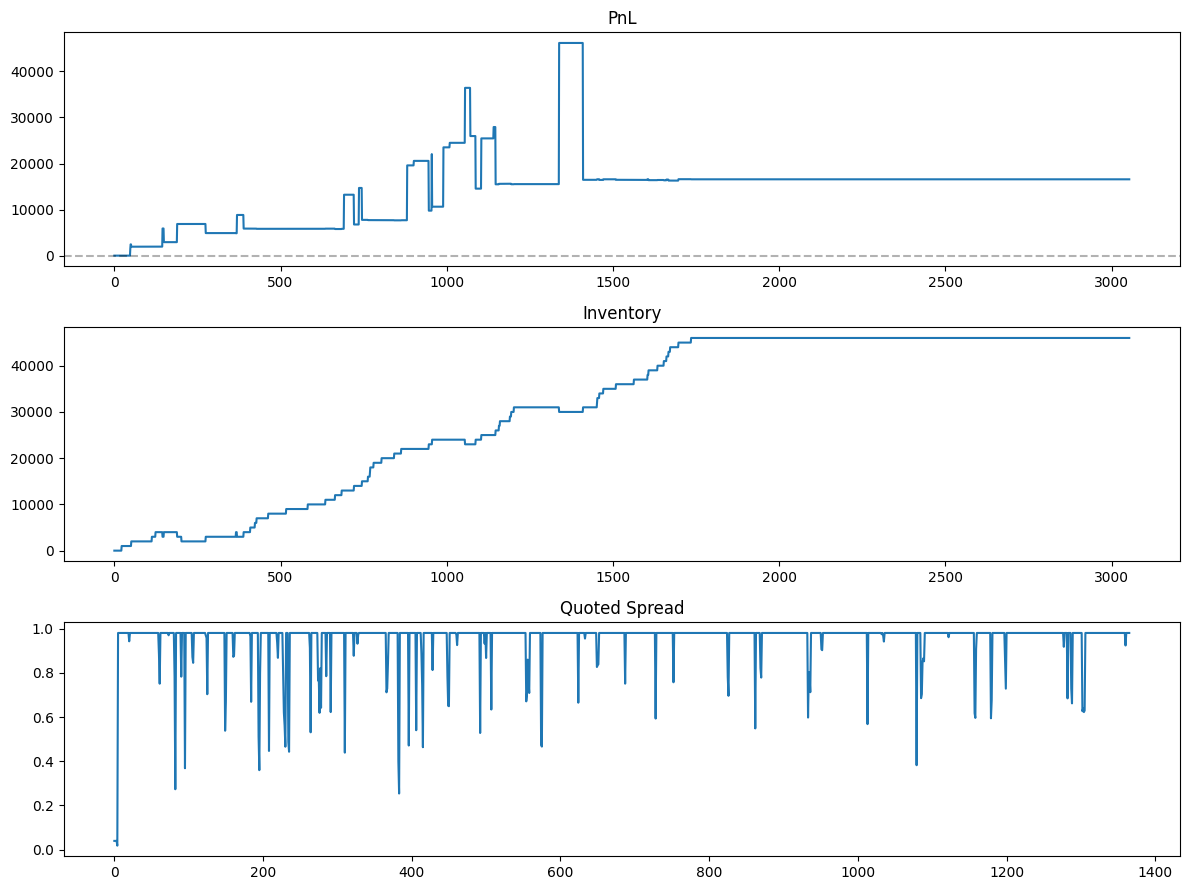

In [47]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9))
axes[0].plot(sim.pnl_history) 
axes[0].set_title('PnL') 
axes[0].axhline(0, color='k', ls='--', alpha=0.3)

axes[1].plot(sim.inventory_history) 
axes[1].set_title('Inventory')

spreads = [q['spread'] for q in sim.quotes_history if q.get('active')]
axes[2].plot(spreads) 
axes[2].set_title('Quoted Spread')

plt.tight_layout() 
plt.show()

## Explanation

- We quote around the mid, buy at our bid, and sell at our ask. This captures the spread.
- Inventory skew helps keep our position from getting too large.
- Pauses avoid trading when risk is high (big spreads or high volatility).

What worked:
- Spread capture is consistent when the market crosses our quotes.
- Inventory stayed within limits because of skew and pauses.

What didn’t:
- Fill logic is basic (no queue).
- Snapshot data only gives periodic “pictures” of the market. It doesn’t include tick-by-tick changes, order book updates, trade timestamps, or quote lifetimes, so we miss short-lived moves and execution timing effects.

Next changes:
- Add fees/slippage and a more realistic fill model.
- Use time-stamped data to test refresh rules and execution timing.
- Tune parameters by market and volatility regime.

# BONUS

## A) Why Negative-Risk Markets Behave Differently

A negative-risk market occurs when the sum of all outcome probabilities exceeds 100%. For example, if the Yes outcome trades at $0.55 (55%) and the No outcome trades at $0.50 (50%), the total is 105%, creating a 5% overflow. This happens because market makers post spreads on both sides, everyone adds their own risk premium, and prices don't perfectly balance in real time.

These markets behave differently from regular markets in several ways. First, there's no free arbitrage opportunity, buying both outcomes would cost $1.05 but only pay out $1.00, resulting in  a guaranteed loss. Second, competition among market makers becomes much tighter as they fight to squeeze spreads and capture volume. Third, adverse selection risk is higher because at least one side must be mispriced, and informed traders actively exploit these mispricings. Finally, these markets tend to be more volatile as market makers constantly adjust their quotes to avoid being stuck on the wrong side.

## B) Simple Rule for Detecting Informed Trading

Use flow direction + price movement:

### Rule: Sustained One-Sided Flow

```python
def detect_informed_trading(recent_trades, window=10):
    if len(recent_trades) < window:
        return False
    
    buys = sum(1 for t in recent_trades[-window:] if t['side'] == 'buy')
    buy_ratio = buys / window
    
    # 70%+ buys or sells
    if buy_ratio > 0.7 or buy_ratio < 0.3:
        return True  

    return False
```

This work because random traders split like 50/50 and informed traders consistently trade one direction.

Example:
- Last 10 trades: 9 buys, 1 sell → 90% buy flow → informed signal
- Action: Widen spreads immediately, especially on the ask side

Add price confirmation:
- If heavy buying AND price rising → definitely informed (flow causing price impact)
- If heavy selling AND price falling → definitely informed (flow causing price impact)
- If flow and price disagree → might just be inventory rebalancing (not informed)